# Optimal transport in a fluid test case

#### *Paper*:        Latent feedback control of distributed systems in multiple scenarios through deep learning-based reduced order models
#### *Authors*:      M.Tomasetto, A.Manzoni, F.Braghin
#### *Affiliations*: Department of Mechanical Engineering (Politecnico di Milano), MOX - Department of Mathematics (Politecnico di Milano)

In [1]:
#IMPORT LIBRARIES

from dolfin import *
from dolfin_adjoint import *
from math import log, exp
import torch
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from IPython.display import clear_output as clc
from IPython.display import display
import time

from dlroms.cores import CPU  # For swapping cores
import dlroms.fespaces as fe  # Handles finite element spaces
import dlroms.geometry as geo # Mesh creation
from dlroms.roms import num2p # Percentage format

import seaborn as sns
teal = sns.light_palette("teal", 15)
magenta = sns.dark_palette("magenta", 15)
red = sns.light_palette("orangered", 15)
navy = sns.light_palette("navy", 15)

set_log_level(LogLevel.ERROR)

# State problem

Fokker-Planck equation
\begin{cases}
     \dfrac{\partial y}{\partial t} + \nabla \cdot (- \nu \nabla y + \mathbf{u} y + \mathbf{v} y) = 0 \qquad &\mathrm{in} \ \Omega \times (0,T]  \\
             (-\nu \nabla y + \mathbf{u} y + \mathbf{v} y) \cdot \mathbf{n} = 0  \qquad &\mathrm{on} \ \partial \Omega  \times (0,T] \\
       y(0) = y_0 \qquad &\mathrm{in} \ \Omega \times \{t = 0\}
\end{cases}


where $\Omega$ is the domain of interest (visualised below) with boundary $\partial \Omega$, $T>0$ is the final time, $y: \Omega \times [0,T] \to \mathbb R$ is the unknown state field, $\mathbf{u}:\Omega \times [0,T] \to \mathbb R^2$ is the control velocity field, $\mathbf{v}:\Omega \to \mathbb R^2$ is the fluid flow velocity field computed via steady Navier-Stokes, $\nu$ is the diffusion coefficient, $\mathbf{n}$ is the normal versor and $y_0$ is the initial datum

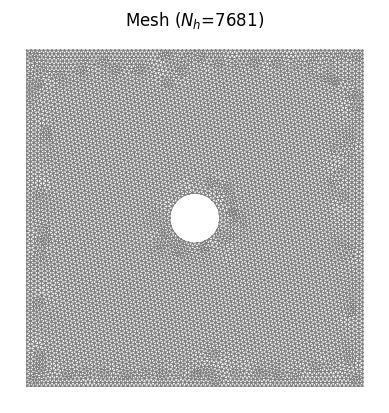

In [2]:
# CREATE THE MESH FOR THE STATE PROBLEM

domain = geo.Rectangle((-1.0, -1.0), (1.0, 1.0)) - geo.Circle((0.0, 0.0), 0.15)
h = 0.05
mesh = geo.mesh(domain, stepsize = h)
mesh = refine(mesh)

plot(mesh, color = "grey", linewidth = 0.75)
plt.title("Mesh ($N_{h}$=%d)" % mesh.num_vertices())
plt.axis("off");

In [3]:
# DEFINE MEASURES

dx = Measure("dx", domain = mesh)

ds = Measure("ds", domain = mesh)

In [4]:
# DEFINE THE CONTROL AND THE STATE SPACE

Uh = VectorElement('CG', mesh.ufl_cell(), 1)
Uh = FunctionSpace(mesh, Uh)
ncontrol = Uh.dim()

Yh = Uh.sub(0).collapse()
nstate = Yh.dim()

In [5]:
# DEFINE THE FLUID FLOW VELOCITY AND PRESSURE SPACES

Vh = VectorElement('CG', mesh.ufl_cell(), 2)
Ph = FiniteElement('CG', mesh.ufl_cell(), 1)
VPh = FunctionSpace(mesh, Vh * Ph)
Vh = VPh.sub(0).collapse()
Ph = VPh.sub(1).collapse()

nvelocity = Vh.dim()
npressure = Ph.dim()

In [6]:
# DEFINE THE STATE PROBLEM SOLVER

diffusion = 0.001
mu = 0.01
beta = 0.2
beta_g = 0.2

def gaussian_generator(params):
    """
    Generate a 2D Gaussian starting from the mean position
    Input: mean coordinate
    Output: 2D Gaussian function
    """
    y = Expression('10 / pi * exp(- 10*(x[0] - x0)*(x[0] - x0) - 10*(x[1] - x1)*(x[1] - x1))', degree = 1, x0 = params[0], x1 = params[1])
    return interpolate(y, Yh)

def compute_velocity(params):
    """
    Compute steady Navier-Stokes velocity via Newton method
    Input: inflow velocity parameters
    Output: steady Navier-Stokes velocity
    """
    
    mod_in = params[0]
    alpha_in = params[1]
    
    # Parabolic BC on the inflow
    v_in = Expression(('(x[0] + 1.0) * (1.0 - x[0]) * mod_in * sin(alpha_in)','mod_in * cos(alpha_in)'), degree = 1, mod_in = mod_in, alpha_in = alpha_in)
    inflow = DirichletBC(VPh.sub(0), v_in, "on_boundary && x[1] <= -0.9")
    
    # Free-slip BC on the wall
    wall = DirichletBC(VPh.sub(0).sub(0), 0.0, "on_boundary && (x[0] >= 0.9 || x[0] < -0.9)")

    # No-slip BC on the obstacle
    obstacle = DirichletBC(VPh.sub(0), (0.0, 0.0), "on_boundary && x[0] < 0.16 && x[0] > -0.16 && x[1] < 0.16 && x[1] > -0.16")

    # Solve state equation
    w, q = TestFunctions(VPh)
    vp = Function(VPh)
    v, p = split(vp)

    F = mu * inner(grad(v), grad(w)) * dx + dot(dot(grad(v), v), w) * dx - p * div(w) * dx - q * div(v) * dx
    solve(F == 0, vp, [inflow, wall, obstacle])
    v, p = vp.split(deepcopy=True)

    return v

def compute_state(ut, v, y0, dt, ntimesteps, yd = None):
    """
    Compute the state trajectory
    Input: control, initial condition, time step, number of timesteps and target state
    Output: time-dependent solution of the Fokker-Planck equation
    """
    
    u = Function(Uh)
    
    mod_in = project(v[1], Yh)(0,-1)

    yt = CPU.zeros(ntimesteps + 1, nstate)
    yt[0] = CPU.tensor(y0.vector())

    J = 0.0

    for i in range(ntimesteps):

        u.assign(ut[i])
            
        w = TestFunction(Yh)
        y = TrialFunction(Yh)

        a = inner(y, w) * dx + 0.5 * dt * (diffusion + mod_in * h / 2) * inner(grad(y), grad(w)) * dx - 0.5 * dt * y * project(u.sub(0), Yh) * w.dx(0) * dx - 0.5 * dt * y * project(v[0], Yh) * w.dx(0) * dx - 0.5 * dt * y * project(u.sub(1), Yh) * w.dx(1) * dx - 0.5 * dt * y * project(v[1], Yh) * w.dx(1) * dx
        L = inner(y0, w) * dx - 0.5 * dt * (diffusion + mod_in * h / 2) * inner(grad(y0), grad(w)) * dx + 0.5 * dt * y0 * project(u.sub(0), Yh) * w.dx(0) * dx + 0.5 * dt * y0 * project(v[0], Yh) * w.dx(0) * dx + 0.5 * dt * y0 * project(u.sub(1), Yh) * w.dx(1) * dx + 0.5 * dt * y0 * project(v[1], Yh) * w.dx(1) * dx
    
        y = Function(Yh)
        solve(a == L, y)
        
        y0.assign(y)
        yt[i+1] = CPU.tensor(y.vector())

        if yd is not None:
            J += 0.5 * assemble(inner(y - yd, y - yd) * dx + inner(y, y) * ds + 0.5 * beta * inner(u, u) * dx + 0.5 * beta_g * inner(grad(u), grad(u)) * dx)
             
    return yt, J

In [7]:
# SOLVE THE STATE PROBLEM

dt = Constant(0.25)
T = 1.5
ntimesteps = round(T / dt)

v_in_params = [0.5, 0.0]
v = compute_velocity(v_in_params)

y0 = gaussian_generator([-0.5, 0.0])
yd = gaussian_generator([0.5, 0.0])

ut = []
for i in range(ntimesteps):
    ut.append(Function(Uh))

yt, J = compute_state(ut, v, y0, dt, ntimesteps, yd)
clc()

set_working_tape(Tape());

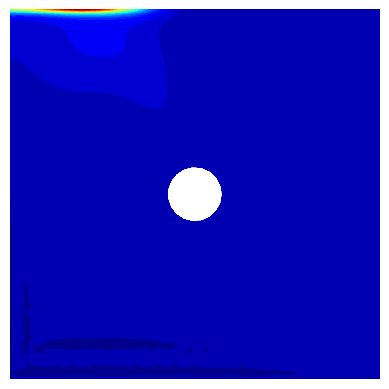

In [8]:
# UNCONTROLLED TRAJECTORY (PLOT)

def plot_state_trajectory(yt):
    """
    State trajectory gif
    Input: state snapshot values
    """
    
    for i in range(ntimesteps + 1):
        fe.plot(yt[i], Yh, cmap = "jet", levelcurves = True)
        display(plt.gcf())
        plt.close()
        time.sleep(0.5)
        clc(wait=True)

plot_state_trajectory(yt)

# Snapshots generation

### PDE-constrained Optimisation

Consider the optimal transport problem

$$
\min_{y,\mathbf{u}} \frac{1}{2} \int_0^T \int_{\Omega} (y - y_d)^2 + \int_0^T \int_{\partial \Omega} y^2 + \frac{\beta}{2} \int_0^T \int_{\Omega} ||\mathbf{u}||^2 + \frac{\beta_g}{2}  \int_0^T \int_{\Omega} ||\nabla \mathbf{u}||^2 
$$

where $y_d$ is the target state. Physically, this setup corresponds to minimising the discrepancy between current and target state over the domain $\Omega$ and in the time interval $[0,T]$, keeping the state far away from the domain boundaries $\partial \Omega$. To avoid overconsuming and irregular controls, the norm of the control and its gradient are penalised via the regularisation terms.

In [ ]:
# GENERATE SNAPSHOTS (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

from dlroms.ocp import snapshots

dt = Constant(0.25)
T = 1.5
ntimesteps = round(T / dt)

ntrajectories = 150
ntrain = round(0.9 * ntrajectories)
ntrain *= ntimesteps
nsnapshots = ntrajectories * ntimesteps
nparams = 3

y0_ranges = [(-0.5, -0.5), (-0.5, 0.5)] # Initial datum parameters: mean coordinates of the initial datum (x-coordiante fixed)
yd_ranges = [(0.5, 0.5), (-0.5, 0.5)] # Scenario paramters: mean coordinates of the target position (x-coordiante fixed)
v_in_ranges = [(0.1, 1.0), (-1.0, 1.0)] # Scenario paramters: intensity of the inflow velocity and angle of attack 

def sampler(seed):
    """
    Generate a random sample of scenario parameters and the corresponding optimal pair
    Input: seed
    Output: scenario parameters, optimal state and control
    """
    
    y0_params = [0] * len(y0_ranges)
    for i in range(len(y0_ranges)):
        y0_params[i] = ((y0_ranges[i][1] - y0_ranges[i][0]) * CPU.rand() + y0_ranges[i][0]).item()  
    y0 = gaussian_generator(y0_params)

    yd_params = [0] * len(yd_ranges)
    for i in range(len(yd_ranges)):
        yd_params[i] = ((yd_ranges[i][1] - yd_ranges[i][0]) * CPU.rand() + yd_ranges[i][0]).item()  
    yd = gaussian_generator(yd_params)
    
    v_in_params = [0] * len(v_in_ranges)
    for i in range(len(v_in_ranges)):
        v_in_params[i] = ((v_in_ranges[i][1] - v_in_ranges[i][0]) * CPU.rand() + v_in_ranges[i][0]).item()  

    v = compute_velocity(v_in_params)
    
    set_working_tape(Tape()) # Reset forward model annotated by dolfin adjoint 

    ut = []
    for i in range(ntimesteps):
        ut.append(Function(Uh))
    
    yt, J = compute_state(ut, v, y0, dt, ntimesteps, yd)

    control = [Control(u) for u in ut]

    Jhat = ReducedFunctional(J, control)

    ut_opt = minimize(Jhat, method = 'L-BFGS-B', options = {'disp': True, 'maxiter': 500})

    y0_new = gaussian_generator(y0_params) # New y0 since the original y0 modified in compute_state
    
    yt_opt, J_opt = compute_state(ut_opt, v, y0_new, dt, ntimesteps, yd)

    set_working_tape(Tape())    

    ut_opt_vals = CPU.zeros(ntimesteps, ncontrol)
    params_vals = CPU.zeros(ntimesteps, nparams)
    
    for i in range(ntimesteps):
        ut_opt_vals[i] = CPU.tensor(ut_opt[i].vector())
        params_vals[i, 0] = CPU.tensor(yd_params[1])
        params_vals[i, 1:] = CPU.tensor(v_in_params)
    
    return params_vals, yt_opt, ut_opt_vals

snapshots(ntrajectories, sampler, core = CPU, verbose = True, filename = 'Data/OptimalTransportFluid')

In [9]:
# LOAD SNAPSHOTS MATRICES

dt = Constant(0.25)
T = 1.5
ntimesteps = round(T / dt)

ntrajectories = 150
ntrain = round(0.9 * ntrajectories)
ntrainY = ntrain * (ntimesteps + 1)
ntrain *= ntimesteps
nsnapshots = ntrajectories * ntimesteps
nparams = 3

y0_ranges = [(-0.5, -0.5), (-0.5, 0.5)] # Initial datum parameters: mean coordinates of the initial datum (x-coordiante fixed)
yd_ranges = [(0.5, 0.5), (-0.5, 0.5)] # Scenario paramters: mean coordinates of the target position (x-coordiante fixed)
v_in_ranges = [(0.1, 1.0), (-1.0, 1.0)] # Scenario paramters: intensity of the inflow velocity and angle of attack 

filename = 'Data/OptimalTransportFluid'
Data = np.load("%s.npz" % filename.replace(".npz",""))

Y = CPU.tensor(Data["y"])
U = CPU.tensor(Data["u"])
MU = CPU.tensor(Data["mu"])

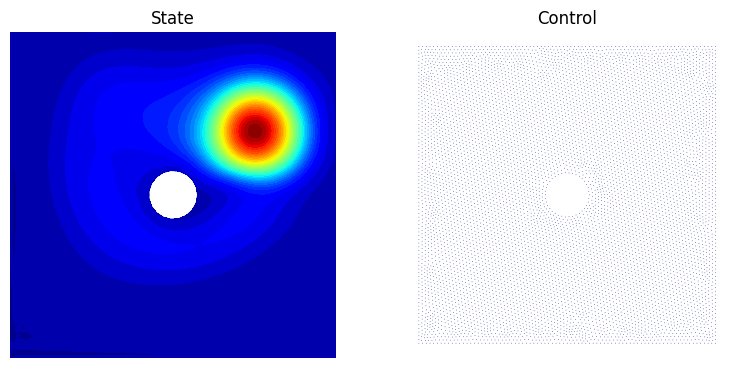

In [10]:
# TRAJECTORY EXAMPLE (PLOT)

def plot_trajectory(Y, U):
    """
    State and control trajectory gif
    Input: state and control snapshot values
    """
    
    for i in range(ntimesteps + 1):
        plotlist = [Y[i], U[i]] if i != ntimesteps else [Y[i], U[i-1]*0]
        fe.multiplot(plotlist, (10, 10), (Yh, Uh), titles = ("State", "Control"), size = 5, cmap = "jet", levelcurves = True, scale = 10)
        display(plt.gcf())
        plt.close()
        time.sleep(0.5)
        clc(wait=True)
        
which = 0

plot_trajectory(Y[which], U[which])

In [11]:
# SPLIT THE STATE MATRIX

Y0 = Y[:,:ntimesteps,:]
Y1 = Y[:,1:,:]

In [12]:
# RESHAPE MATRICES

Y = Y.reshape(-1, nstate)
Y0 = Y0.reshape(-1, nstate)
Y1 = Y1.reshape(-1, nstate)
U = U.reshape(-1, ncontrol)
MU = MU.reshape(-1, nparams)

In [13]:
# SPLIT CONTROL MATRIX IN THE X AND Y COMPONENTS

split_U = lambda U: (U[:, 0 : U.shape[1] : 2], U[:, 1 : U.shape[1] : 2])
Ux, Uy = split_U(U)

In [14]:
# MERGE FUNCTION TO BUILD THE SNAPSHOTS MATRIX FROM ITS X AND Y COMPONENTS

def merge_U(Ux, Uy):
    ncontrol = Ux.shape[1] + Uy.shape[1]
    U = CPU.zeros(Ux.shape[0], ncontrol)
    U[:, 0 : ncontrol : 2] = Ux
    U[:, 1 : ncontrol : 2] = Uy
    return U

In [15]:
# PLOT FUNCTIONS 

import colormaps as cmaps
from matplotlib import colors

mesh_plot = geo.mesh(domain, stepsize = 0.2)

Vh_plot = VectorElement('CG', mesh_plot.ufl_cell(), 1)
Vh_plot = FunctionSpace(mesh_plot, Vh_plot)

clc()

white = colors.LinearSegmentedColormap.from_list("", ["white", "white"])

ice = sns.color_palette("icefire", as_cmap=True).colors
col = [ice[i] for i in np.concatenate((np.arange(128,0,-20), np.arange(254,160,-12)))]
col.insert(0, "black")
cmap = colors.LinearSegmentedColormap.from_list("", col)

def plot_u(U, vmin = None, vmax = None, colorbar = True, shrink = 1, format = None, orientation = 'vertical', scale = None, error = False):
    """
    Control snapshot plot
    Input: control snapshot values
    """
    
    u = Function(Uh)
    u.vector()[:] = U

    fig = plot(sqrt(u**2), cmap = cmap, vmin = vmin, vmax = vmax)
    if colorbar:
        plt.colorbar(fig, shrink = shrink, format = format, orientation = orientation, pad = 0.05)

    if not error:
        plot(dolfin.project(u, Vh_plot), cmap = white, alpha = 0.6, scale = scale)
    
    plt.axis("off");

def plot_y(Y, v_params, scale = None, vmin = None, vmax = None, colorbar = True, shrink = 1, format = "%0.2f"):
    """
    State snapshot plot
    Input: state snapshot values and scenario parameters
    """
    
    v = compute_velocity(v_params)
    v.set_allow_extrapolation(True)

    fe.plot(Y, Yh, cmap = "jet", levelcurves = True, vmin = vmin, vmax = vmax, colorbar = colorbar, shrink = shrink, format = format)

    plot(dolfin.project(v, Vh_plot), cmap = white, alpha = 0.6, scale = scale)

    plt.axis("off");

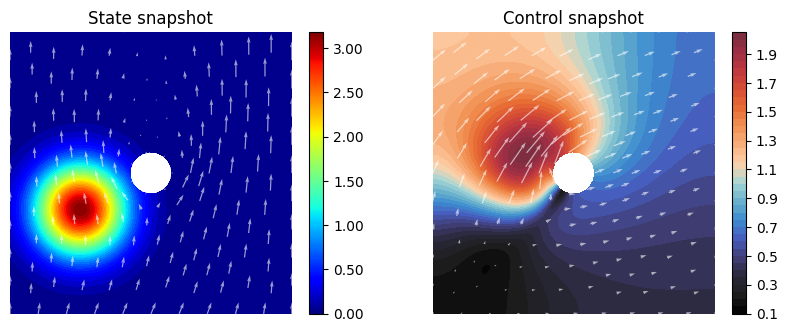

In [16]:
# SNAPSHOT EXAMPLE (PLOT)

which = 0

plt.figure(figsize = (10, 10))

plt.subplot(1,2,1)
plot_y(Y[which], MU[which], vmin = 0, shrink = 0.365)
plt.title("State snapshot")

plt.subplot(1,2,2)
plot_u(U[which], shrink = 0.365)
plt.title("Control snapshot");

# POD-DL-ROM

In [17]:
# IMPORT FUNCTIONS FOR POD AND NEURAL NETWORKS

from dlroms.dnns import Dense, Weightless # Neural networks handling
from dlroms.roms import projectdown, projectup, mre, mse, euclidean # Proper orthogonal decomposition
from dlroms.ocp import L2 # Error metrics

l2_state = L2(mesh, Yh, measure = dx, core = CPU)
l2_control = L2(mesh, Uh, measure = dx, core = CPU)

mse = mse(euclidean)
mre = mre(euclidean)

In [18]:
# DEFINE THE OCP OBJECT TO HANDLE REDUCTIONS AND PREDICTIONS

from dlroms.ocp import OCP

ocp = OCP(ntrain)
ocpY = OCP(ntrainY)

## State reduction - POD

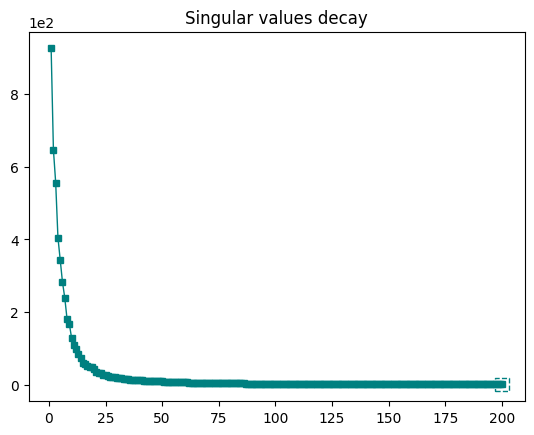

In [19]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR Y

ky = 200 # Number of POD modes

Y_POD, Y_reconstructed, pod_Y, eig_Y = ocpY.POD(Y, k = ky, color = teal[14])

Y0_POD = projectdown(pod_Y, Y0).squeeze(-1)
Y0_reconstructed = projectup(pod_Y, Y0_POD)
Y1_POD = projectdown(pod_Y, Y1).squeeze(-1)
Y1_reconstructed = projectup(pod_Y, Y1_POD)

In [20]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

print("POD reconstruction errors:")
print("")
print("Mean relative error on Y: %s." % num2p(mre(Y[ntrainY:], Y_reconstructed[ntrainY:])))
print("L2 mean relative error on Y: %s." % num2p(l2_state.mre(Y[ntrainY:], Y_reconstructed[ntrainY:])))

POD reconstruction errors:

Mean relative error on Y: 0.29%.
L2 mean relative error on Y: 0.26%.


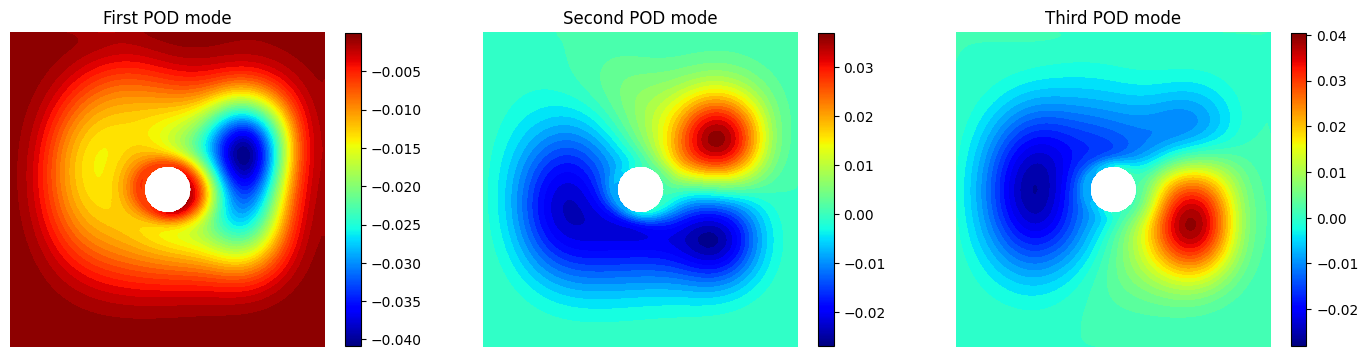

In [21]:
# POD MODES (PLOT)

plotlist = [pod_Y[0], pod_Y[1], pod_Y[2]]
fe.multiplot(plotlist, (10, 10), Yh, titles = ("First POD mode", "Second POD mode", "Third POD mode"), size = 6, cmap = "jet", levelcurves = True, colorbar = True)

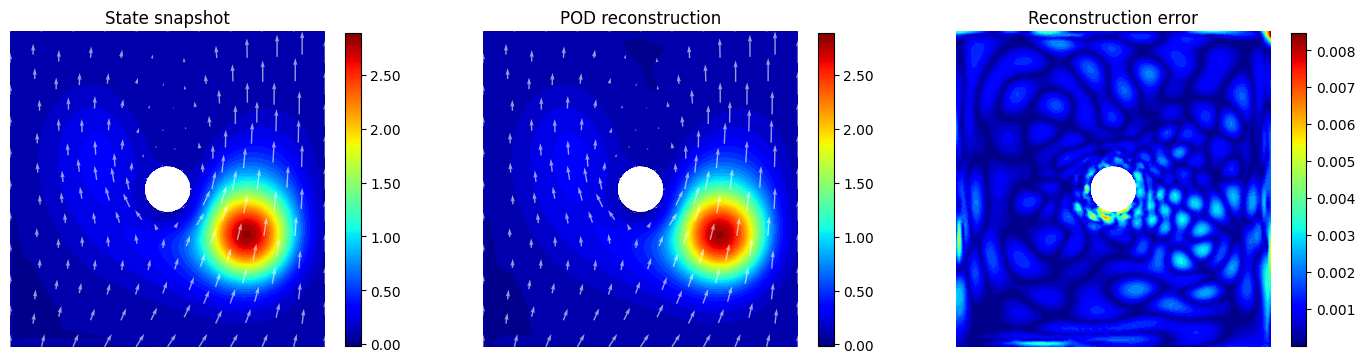

In [22]:
# FOM vs POD RECONSTRUCTION (PLOTS)

which = -1

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_y(Y[which], MU[which, 1:], shrink = 0.8)
plt.title("State snapshot")

plt.subplot(10, 10, 2)
plot_y(Y_reconstructed[which], MU[which, 1:], shrink = 0.8)
plt.title("POD reconstruction")

plt.subplot(10, 10, 3)
fe.plot(((Y[which] - Y_reconstructed[which])**2).sqrt(), Yh, levelcurves = True, cmap = "jet", colorbar = True, shrink = 0.8)
plt.title("Reconstruction error");

## Control reduction - POD

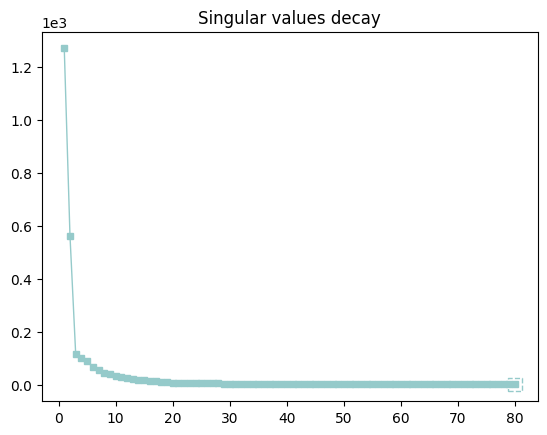

In [23]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR Ux

kux = 80 # Number of POD modes

Ux_POD, Ux_reconstructed, pod_Ux, eig_Ux = ocp.POD(Ux, k = kux, color = teal[5])

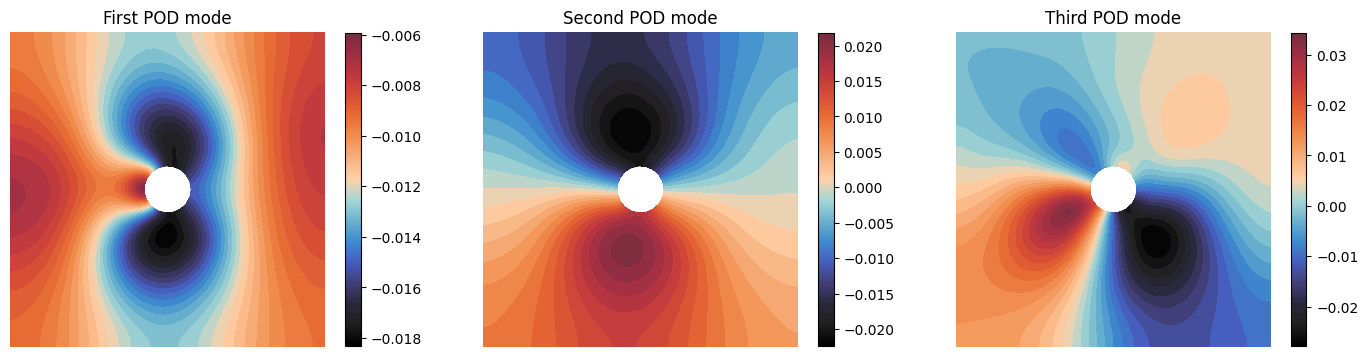

In [24]:
# POD MODES (PLOT)

plotlist = [pod_Ux[0], pod_Ux[1], pod_Ux[2]]
fe.multiplot(plotlist, (10, 10), Yh, titles = ("First POD mode", "Second POD mode", "Third POD mode"), size = 6, cmap = cmap, levelcurves = True, colorbar = True)

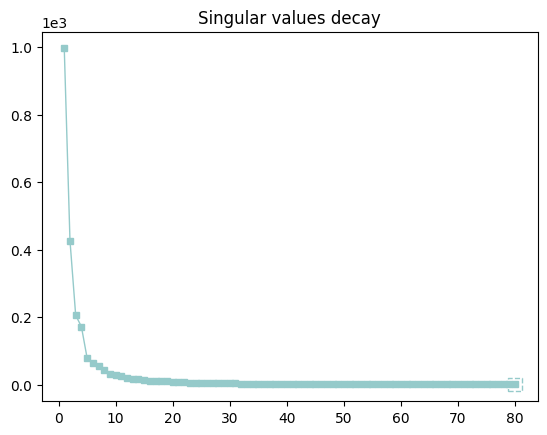

In [25]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR Y

kuy = 80 # Number of POD modes

Uy_POD, Uy_reconstructed, pod_Uy, eig_Uy = ocp.POD(Uy, k = kuy, color = teal[5])

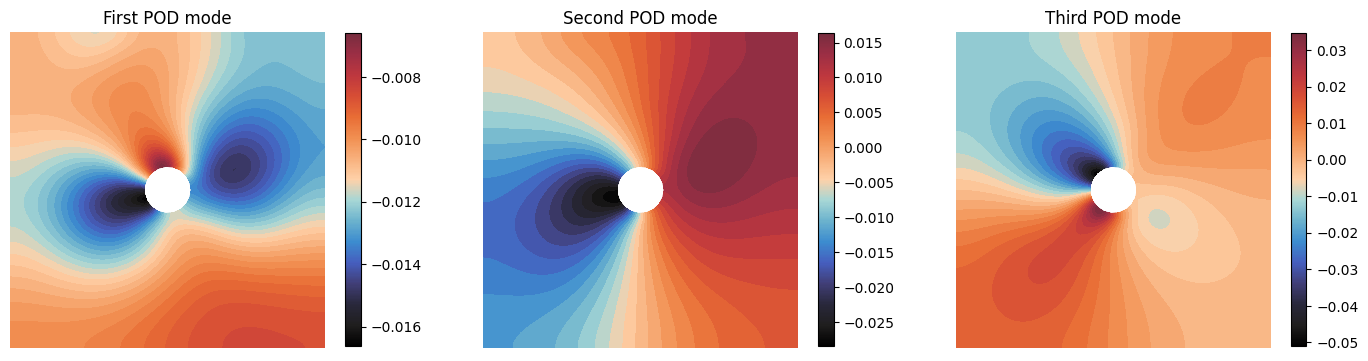

In [26]:
# POD MODES (PLOT)

plotlist = [pod_Uy[0], pod_Uy[1], pod_Uy[2]]
fe.multiplot(plotlist, (10, 10), Yh, titles = ("First POD mode", "Second POD mode", "Third POD mode"), size = 6, cmap = cmap, levelcurves = True, colorbar = True)

In [27]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

U_POD = torch.cat((Ux_POD, Uy_POD), 1)

U_reconstructed = merge_U(Ux_reconstructed, Uy_reconstructed)

print("POD reconstruction errors:")
print("")
print("Mean relative error on U: %s." % num2p(mre(U[ntrain:], U_reconstructed[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux[ntrain:], Ux_reconstructed[ntrain:], Uy[ntrain:], Uy_reconstructed[ntrain:])))

POD reconstruction errors:

Mean relative error on U: 0.29%.
L2 mean relative error on U: 0.28%.


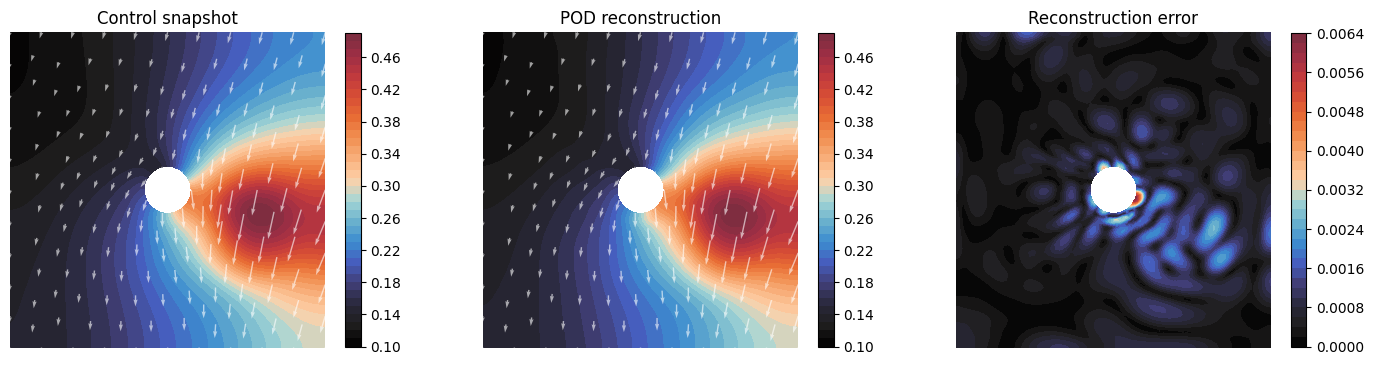

In [28]:
# FOM vs POD RECONSTRUCTION (PLOTS)

which = -1

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_u(U[which], shrink = 0.8)
plt.title("Control snapshot")

plt.subplot(10, 10, 2)
plot_u(U_reconstructed[which], shrink = 0.8)
plt.title("POD reconstruction")

plt.subplot(10, 10, 3)
plot_u(((U[which] - U_reconstructed[which])**2).sqrt(), shrink = 0.8, error = True)
plt.title("Reconstruction error");

## Neural networks training
The following neural networks are considered
- State autoencoder: $ \quad \hspace{10mm} \mathbf{y}_{POD, rec} = \varphi_E^y(\varphi_D^y(\mathbf{y}_{POD}))$
- Control autoencoder: $ \hspace{10.5mm} \mathbf{u}_{POD, rec} = \varphi_E^u(\varphi_D^u(\mathbf{u}_{POD}))$
- Policy: $\hspace{4.5cm} \mathbf{u}_{N} = \pi(\mathbf{y}_{N}, \boldsymbol{\mu}_{s})$

where $\; \mathbf{y}_{N} = \varphi_E^y(\mathbf{y}_{POD}) \;$ and $\; \mathbf{u}_{N} = \varphi_E^u(\mathbf{u}_{POD}) \;$

In [29]:
# AUTOENCODERS AND POLICY DEFINITIONS

ny = 14 # State latent dimension
encoder_Y = Dense(ky, 100) + Dense(100, ny)
decoder_Y = Dense(ny, 100) + Dense(100, 100) + Dense(100, ky, activation = None)
autoencoder_Y = encoder_Y + decoder_Y

nu = 14 # Latent dimension
encoder_U = Dense(kux + kuy, 100) + Dense(100, nu)
decoder_U = Dense(nu, 100) + Dense(100, 100) + Dense(100, kux + kuy, activation = None)
autoencoder_U = encoder_U + decoder_U

class Embedd(Weightless): # First layer with some fixed transformation of the input (driven by the problem)
    def forward(self, x):
        return torch.cat([x, x[:,[-3]].tan(), x[:,[-1]].tan(), x[:,[-2]]*x[:,[-1]].sin(), x[:,[-2]]*x[:,[-1]].cos()], axis = 1)

policy = Embedd() + Dense(ny + nparams + 4, 50) + Dense(50, 50) + Dense(50, 50) + Dense(50, nu, activation = None)

In [30]:
#  NEURAL NETWORKS TRAINING/LOADING

Y0_POD_reconstructed, U_POD_reconstructed, U_POD_hat = ocp.latent_policy(Y0_POD, U_POD, MU, encoder_Y, decoder_Y, encoder_U, decoder_U, policy, training = False, save = False, path = 'NN/OptimalTransportFluid/', epochs = 1000, weights = [0.001, 0.001, 0.001], optim = torch.optim.LBFGS, loss = mse, error = mre, best = False)

In [31]:
# POD+AE RECONSTRUCTION ERRORS ON TEST DATA

Y0_reconstructed = projectup(pod_Y, Y0_POD_reconstructed)
Ux_reconstructed = projectup(pod_Ux, U_POD_reconstructed[:,:kux])
Uy_reconstructed = projectup(pod_Uy, U_POD_reconstructed[:,kux:])
U_reconstructed = merge_U(Ux_reconstructed, Uy_reconstructed)

print("POD+AE state reconstruction errors:")
print("")
print("Mean relative error on Y: %s." % num2p(mre(Y0[ntrain:], Y0_reconstructed[ntrain:])))
print("L2 mean relative error on Y: %s." % num2p(l2_state.mre(Y0[ntrain:], Y0_reconstructed[ntrain:])))
print("")
print("POD+AE control reconstruction errors:")
print("")
print("Mean relative error on U: %s." % num2p(mre(U[ntrain:], U_reconstructed[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux[ntrain:], Ux_reconstructed[ntrain:], Uy[ntrain:], Uy_reconstructed[ntrain:])))

POD+AE state reconstruction errors:

Mean relative error on Y: 4.39%.
L2 mean relative error on Y: 4.30%.

POD+AE control reconstruction errors:

Mean relative error on U: 4.43%.
L2 mean relative error on U: 4.41%.


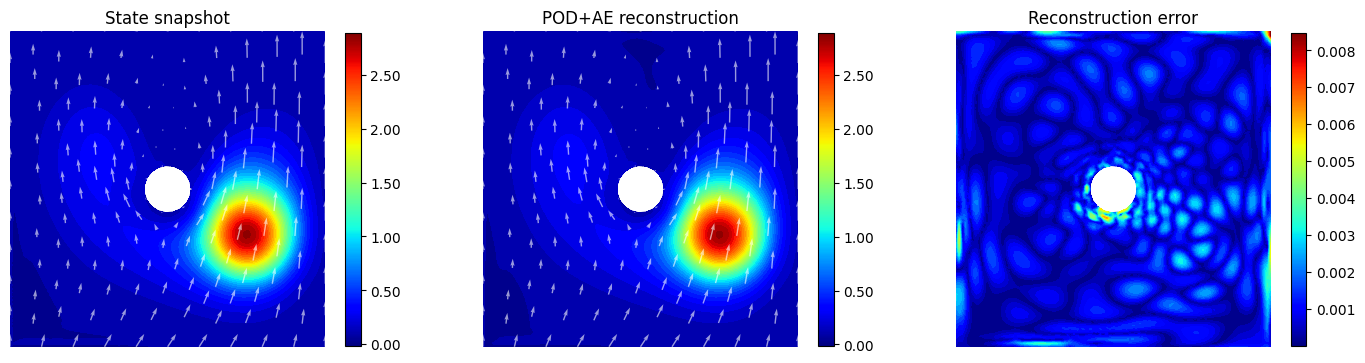

In [32]:
# FOM vs POD+AE RECONSTRUCTION (PLOTS)

which = -1

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_y(Y[which], MU[which, 1:], shrink = 0.8)
plt.title("State snapshot")

plt.subplot(10, 10, 2)
plot_y(Y_reconstructed[which], MU[which, 1:], shrink = 0.8)
plt.title("POD+AE reconstruction")

plt.subplot(10, 10, 3)
fe.plot(((Y[which] - Y_reconstructed[which])**2).sqrt(), Yh, levelcurves = True, cmap = "jet", colorbar = True, shrink = 0.8)
plt.title("Reconstruction error");

Text(0.5, 1.0, 'Reconstruction error')

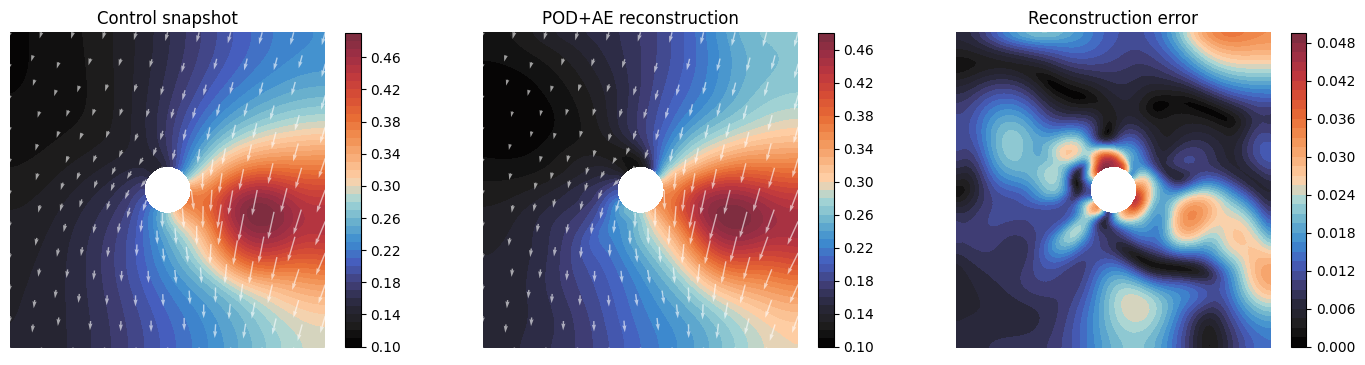

In [33]:
# FOM vs POD+AE RECONSTRUCTION (PLOTS)

which = -1

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_u(U[which], shrink = 0.8)
plt.title("Control snapshot")

plt.subplot(10, 10, 2)
plot_u(U_reconstructed[which], shrink = 0.8)
plt.title("POD+AE reconstruction")

plt.subplot(10, 10, 3)
plot_u(((U[which] - U_reconstructed[which])**2).sqrt(), shrink = 0.8, error = True)
plt.title("Reconstruction error")

In [34]:
# POLICY ERROR ON TEST DATA

Ux_hat = projectup(pod_Ux, U_POD_hat[:,:kux])
Uy_hat = projectup(pod_Uy, U_POD_hat[:,kux:])
U_hat = merge_U(Ux_hat, Uy_hat)

print("Policy interpolation errors:")
print("")
print("Mean relative error on U: %s." % num2p(mre(U[ntrain:], U_hat[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux[ntrain:], Ux_hat[ntrain:], Uy[ntrain:], Uy_hat[ntrain:])))

Policy interpolation errors:

Mean relative error on U: 7.08%.
L2 mean relative error on U: 7.06%.


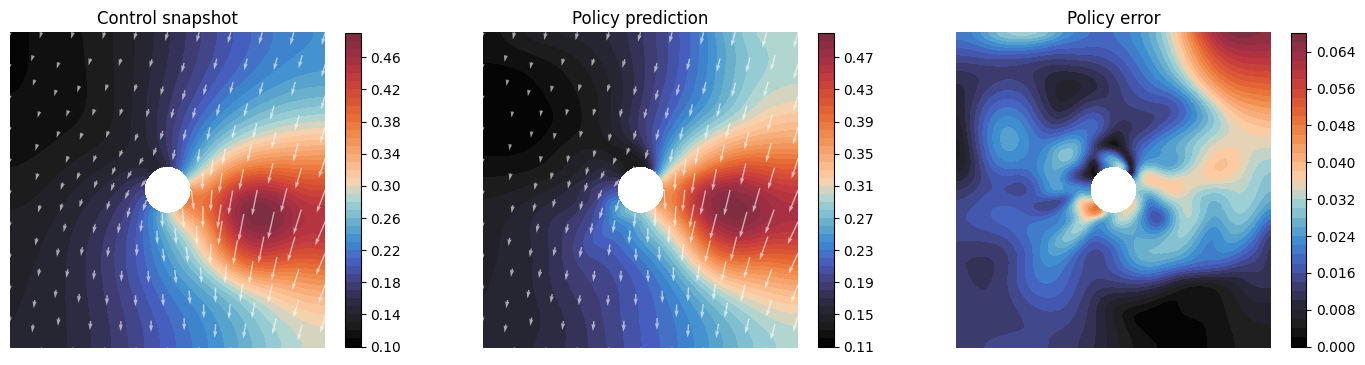

In [35]:
# FOM vs POD RECONSTRUCTION (PLOTS)

which = -1

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_u(U[which], shrink = 0.8)
plt.title("Control snapshot")

plt.subplot(10, 10, 2)
plot_u(U_hat[which], shrink = 0.8)
plt.title("Policy prediction")

plt.subplot(10, 10, 3)
plot_u(((U[which] - U_hat[which])**2).sqrt(), shrink = 0.8, error = True)
plt.title("Policy error");

## Latent feedback loop

In addition to the autoencoders and the policy, we consider also a surrogate model for the dynamics, that is
$$\hspace{0.1cm} \mathbf{y}_{N}(t_{j+1}) = \varphi_N (\mathbf{y}_{N}(t_j), \mathbf{u}_N(t_j), \boldsymbol{\mu}_{s}) \quad \forall j = 1,...,N_t-1$$
where $ \mathbf{y}_{N} = \varphi_E^y(\mathbf{y}_{POD}) \;$ and $\; \mathbf{u}_{N} = \varphi_E^u(\mathbf{u}_{POD}) \;$

In [36]:
# AUTOENCODERS AND POLICY DEFINITIONS

ny = 14 # State latent dimension
encoder_Y_latentloop = Dense(ky, 100) + Dense(100, ny)
decoder_Y_latentloop = Dense(ny, 100) + Dense(100, 100) + Dense(100, ky, activation = None)
autoencoder_Y_latentloop = encoder_Y_latentloop + decoder_Y_latentloop

nu = 14 # Latent dimension
encoder_U_latentloop = Dense(kux + kuy, 100) + Dense(100, nu)
decoder_U_latentloop = Dense(nu, 100) + Dense(100, 100) + Dense(100, kux + kuy, activation = None)
autoencoder_U_latentloop = encoder_U_latentloop + decoder_U_latentloop

class Embedd(Weightless): # First layer with some fixed transformation of the input (driven by the problem)
    def forward(self, x):
        return torch.cat([x, x[:,[-3]].tan(), x[:,[-1]].tan(), x[:,[-2]]*x[:,[-1]].sin(), x[:,[-2]]*x[:,[-1]].cos()], axis = 1)

policy_latentloop = Embedd() + Dense(ny + nparams + 4, 50) + Dense(50, 50) + Dense(50, 50) + Dense(50, nu, activation = None)

phi = Dense(nparams + ny + nu, 50) + Dense(50, 50) + Dense(50, 50) + Dense(50, ny, activation = None)
phi.He() # Initialization

In [37]:
# TRANSFER LEARNING

autoencoder_Y_latentloop.load_state_dict(torch.load('NN/OptimalTransportFluid/autoencoder_Y', weights_only = True))
autoencoder_U_latentloop.load_state_dict(torch.load('NN/OptimalTransportFluid/autoencoder_U', weights_only = True))
policy_latentloop.load_state_dict(torch.load('NN/OptimalTransportFluid/policy', weights_only = True))

autoencoder_Y_latentloop.unfreeze()
autoencoder_U_latentloop.unfreeze()
policy_latentloop.unfreeze()

In [38]:
#  NEURAL NETWORKS TRAINING/LOADING

Y_POD_reconstructed, U_POD_reconstructed, U_POD_hat, Y1_POD_hat = ocp.latent_loop(ntrajectories, Y_POD, U_POD, MU, encoder_Y_latentloop, decoder_Y_latentloop, encoder_U_latentloop, decoder_U_latentloop, policy_latentloop, phi, training = False, initialization = False, save = False, path = 'NN/OptimalTransportFluid/Latentloop/', epochs = 1000, weights = [0.0001, 0.0001, 0.0001, 0.01, 0.01, 0.0001], optim = torch.optim.LBFGS, loss = mse, error = mre, best = False)

In [39]:
# POD+AE RECONSTRUCTION ERRORS ON TEST DATA

Y_reconstructed = projectup(pod_Y, Y_POD_reconstructed)
Ux_reconstructed = projectup(pod_Ux, U_POD_reconstructed[:,:kux])
Uy_reconstructed = projectup(pod_Uy, U_POD_reconstructed[:,kux:])
U_reconstructed = merge_U(Ux_reconstructed, Uy_reconstructed)

print("POD+AE state reconstruction errors:")
print("")
print("Mean relative error on Y: %s." % num2p(mre(Y[ntrainY:], Y_reconstructed[ntrainY:])))
print("L2 mean relative error on Y: %s." % num2p(l2_state.mre(Y[ntrainY:], Y_reconstructed[ntrainY:])))
print("")
print("POD+AE control reconstruction errors:")
print("")
print("Mean relative error on U: %s." % num2p(mre(U[ntrain:], U_reconstructed[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux[ntrain:], Ux_reconstructed[ntrain:], Uy[ntrain:], Uy_reconstructed[ntrain:])))

POD+AE state reconstruction errors:

Mean relative error on Y: 3.71%.
L2 mean relative error on Y: 3.63%.

POD+AE control reconstruction errors:

Mean relative error on U: 4.40%.
L2 mean relative error on U: 4.37%.


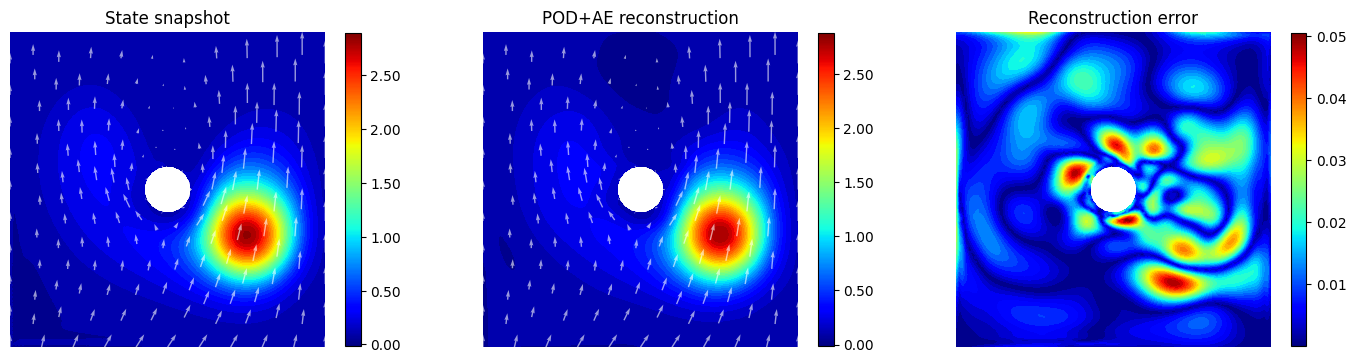

In [40]:
# FOM vs POD+AE RECONSTRUCTION (PLOTS)

which = -1

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_y(Y[which], MU[which, 1:], shrink = 0.8)
plt.title("State snapshot")

plt.subplot(10, 10, 2)
plot_y(Y_reconstructed[which], MU[which, 1:], shrink = 0.8)
plt.title("POD+AE reconstruction")

plt.subplot(10, 10, 3)
fe.plot(((Y[which] - Y_reconstructed[which])**2).sqrt(), Yh, levelcurves = True, cmap = "jet", colorbar = True, shrink = 0.8)
plt.title("Reconstruction error");

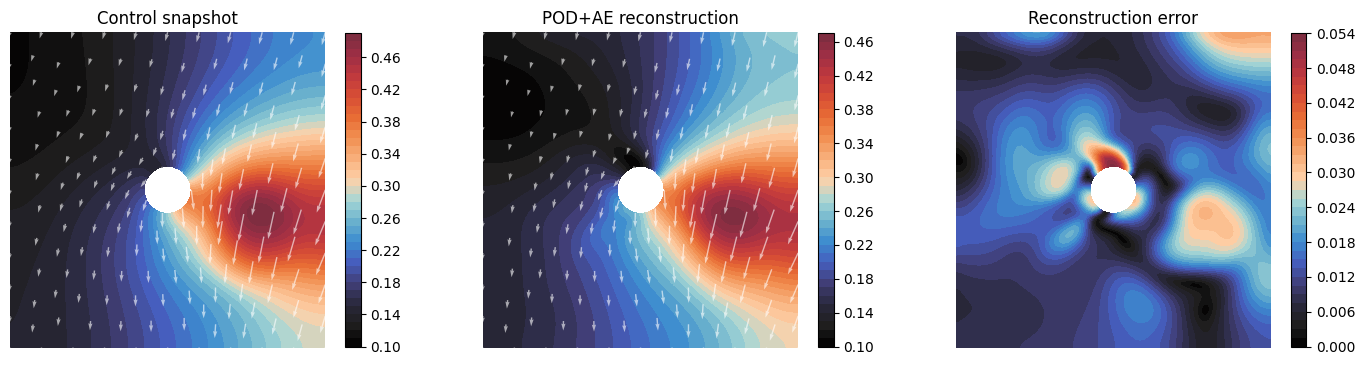

In [41]:
# FOM vs POD+AE RECONSTRUCTION (PLOTS)

which = -1

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_u(U[which], shrink = 0.8)
plt.title("Control snapshot")

plt.subplot(10, 10, 2)
plot_u(U_reconstructed[which], shrink = 0.8)
plt.title("POD+AE reconstruction")

plt.subplot(10, 10, 3)
plot_u(((U[which] - U_reconstructed[which])**2).sqrt(), shrink = 0.8, error = True)
plt.title("Reconstruction error");

In [42]:
# POLICY ERROR ON TEST DATA

Ux_hat = projectup(pod_Ux, U_POD_hat[:,:kux])
Uy_hat = projectup(pod_Uy, U_POD_hat[:,kux:])
U_hat = merge_U(Ux_hat, Uy_hat)

print("Policy interpolation errors:")
print("")
print("Mean relative error on U: %s." % num2p(mre(U[ntrain:], U_hat[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux[ntrain:], Ux_hat[ntrain:], Uy[ntrain:], Uy_hat[ntrain:])))

Policy interpolation errors:

Mean relative error on U: 7.12%.
L2 mean relative error on U: 7.10%.


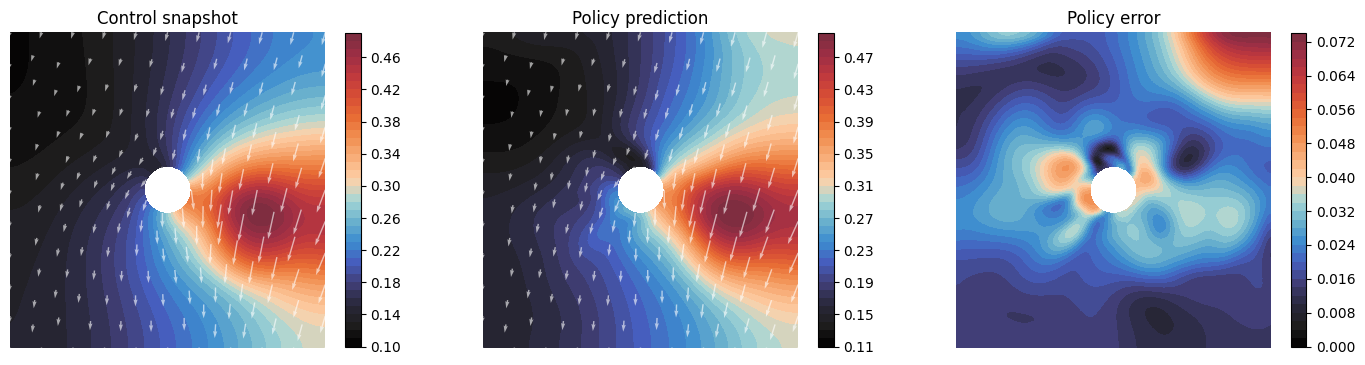

In [43]:
# FOM vs POLICY PREDICTION (PLOTS)

which = -1

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_u(U[which], shrink = 0.8)
plt.title("Control snapshot")

plt.subplot(10, 10, 2)
plot_u(U_hat[which], shrink = 0.8)
plt.title("Policy prediction")

plt.subplot(10, 10, 3)
plot_u(((U[which] - U_hat[which])**2).sqrt(), shrink = 0.8, error = True)
plt.title("Policy error");

In [44]:
# FORWARD MODEL ERROR ON TEST DATA

Y1_hat = projectup(pod_Y, Y1_POD_hat)

print("Forward model interpolation errors:")
print("")
print("Mean relative error on Y: %s." % num2p(mre(Y1[ntrain:], Y1_hat[ntrain:])))
print("L2 mean relative error on Y: %s." % num2p(l2_state.mre(Y1[ntrain:], Y1_hat[ntrain:])))

Forward model interpolation errors:

Mean relative error on Y: 7.29%.
L2 mean relative error on Y: 7.21%.


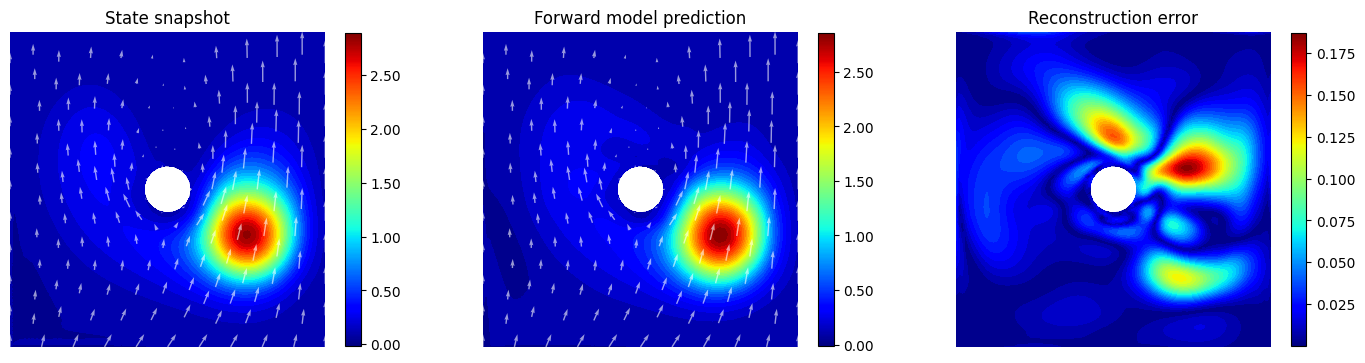

In [45]:
# FOM vs FORWARD MODEL PREDICITON (PLOTS)

which = -1

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_y(Y1[which], MU[which, 1:], shrink = 0.8)
plt.title("State snapshot")

plt.subplot(10, 10, 2)
plot_y(Y1_hat[which], MU[which, 1:], shrink = 0.8)
plt.title("Forward model prediction")

plt.subplot(10, 10, 3)
fe.plot(((Y1[which] - Y1_hat[which])**2).sqrt(), Yh, levelcurves = True, cmap = "jet", colorbar = True, shrink = 0.8)
plt.title("Reconstruction error");

# Test case: real-time optimal transport related to new scenario parameters

In [46]:
# DEFINE INITIAL STATE AND SCENARIO PARAMETERS FOR TESTING

y0_params_test = [0] * len(y0_ranges)
for i in range(len(y0_ranges)):
    y0_params_test[i] = ((y0_ranges[i][1] - y0_ranges[i][0]) * CPU.rand() + y0_ranges[i][0]).item()  
y0_test = gaussian_generator(y0_params_test)

yd_params_test = [0] * len(yd_ranges)
for i in range(len(yd_ranges)):
    yd_params_test[i] = ((yd_ranges[i][1] - yd_ranges[i][0]) * CPU.rand() + yd_ranges[i][0]).item()  

v_in_params_test = [0] * len(v_in_ranges)
for i in range(len(v_in_ranges)):
    v_in_params_test[i] = ((v_in_ranges[i][1] - v_in_ranges[i][0]) * CPU.rand() + v_in_ranges[i][0]).item()  

MU_test = CPU.tensor([yd_params_test[1], v_in_params_test[0], v_in_params_test[1]]).unsqueeze(0)

In [47]:
# COMPUTE THE FLUID VELOCITY FIELD

v = compute_velocity(v_in_params_test)

In [55]:
# OPTIMAL TRAJECTORY PREDICTED BY THE POLICY

Y_test = CPU.zeros(ntimesteps + 1, nstate)
Y_test[0] = CPU.tensor(y0_test.vector())
U_hat_test = CPU.zeros(ntimesteps, ncontrol)

for i in range(ntimesteps):
    Y_DLROM_test = encoder_Y(projectdown(pod_Y, Y_test[i].unsqueeze(0)).squeeze(2))
    U_DLROM_hat_test = policy(torch.cat((Y_DLROM_test, MU_test), 1))
    Ux_hat_test = projectup(pod_Ux, decoder_U(U_DLROM_hat_test)[:,:kux])
    Uy_hat_test = projectup(pod_Uy, decoder_U(U_DLROM_hat_test)[:,kux:])
    U_hat_test[i] = merge_U(Ux_hat_test, Uy_hat_test)

    ut = [fe.asvector(U_hat_test[i], Uh)]
    yt, J = compute_state(ut, v, fe.asvector(Y_test[i], Yh), dt, 1)
    clc()

    Y_test[i+1] = yt[-1]

In [51]:
# OPTIMAL TEST TRAJECTORY (PLOT)

plot_trajectory(Y_test, U_hat_test)

In [56]:
# OPTIMAL TRAJECTORY PREDICTED BY THE POLICY AND THE FORWARD MODEL

Y_test = CPU.zeros(ntimesteps + 1, nstate)
Y_hat_test = CPU.zeros(ntimesteps + 1, nstate)
Y_test[0] = CPU.tensor(y0_test.vector())
Y_hat_test[0] = CPU.tensor(y0_test.vector())
U_hat_test = CPU.zeros(ntimesteps, ncontrol)

for i in range(ntimesteps):
    Y_DLROM_test = encoder_Y_latentloop(projectdown(pod_Y, Y_hat_test[i].unsqueeze(0)).squeeze(2))
    U_DLROM_hat_test = policy_latentloop(torch.cat((Y_DLROM_test, MU_test), 1))
    Ux_hat_test = projectup(pod_Ux, decoder_U_latentloop(U_DLROM_hat_test)[:,:kux])
    Uy_hat_test = projectup(pod_Uy, decoder_U_latentloop(U_DLROM_hat_test)[:,kux:])
    U_hat_test[i] = merge_U(Ux_hat_test, Uy_hat_test)

    Y_hat_test[i+1] = projectup(pod_Y, decoder_Y_latentloop(phi(torch.cat((Y_DLROM_test, U_DLROM_hat_test, MU_test), 1))))

    # Keep track of the actual state of the system (needed only for checking)
    ut = [fe.asvector(U_hat_test[i], Uh)]
    yt, J = compute_state(ut, v, fe.asvector(Y_test[i], Yh), dt, 1)
    clc()

    Y_test[i+1] = yt[-1]

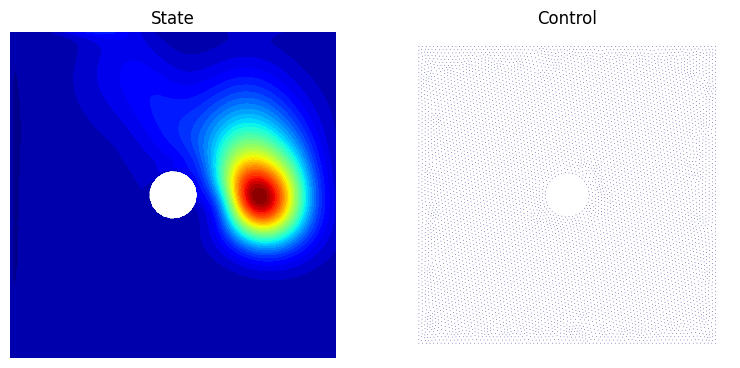

In [57]:
# OPTIMAL TEST TRAJECTORY (PLOT)

plot_trajectory(Y_test, U_hat_test)